# Basics
This notebook will show you the basics to get started using Lightnet.  
Before reading these tutorials, it is strongly recommended to have an understanding of how PyTorch works.
You can find some tutorials on their [website](https://pytorch.org/tutorials/).

The first part of this tutorial will show you how to load the lightnet provided networks and loss functions, as well as where to find all the layers so you can build your own networks.  
After that, we will take a look at the included data processing functionality, so you can easily setup a pipeline to train your networks.  
Finally, we will look at the post-processing that is included in Lightnet, which allows you to save your detection results once you finished training a model.

In [1]:
# Basic imports
import lightnet as ln
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import brambox as bb

# Settings
ln.logger.setConsoleLevel('ERROR')             # Only show error log messages
bb.logger.setConsoleLevel('ERROR')             # Only show error log messages

## Networks
This section will take a closer look at the premade models that are included in lightnet, as well as how to create your own models.

You can find all premade models under [lightnet.models](../api/models.rst#networks).  
They are nothing more than `torch.nn.Module` classes, which implement a forward function.

In [2]:
model = ln.models.TinyYolo()
print(model)

TinyYolo(
  (layers): Sequential(
    (1_convbatch): Conv2dBatchReLU(3, 16, kernel_size=3, stride=1, padding=1, LeakyReLU(negative_slope=0.1, inplace))
    (2_max): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3_convbatch): Conv2dBatchReLU(16, 32, kernel_size=3, stride=1, padding=1, LeakyReLU(negative_slope=0.1, inplace))
    (4_max): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5_convbatch): Conv2dBatchReLU(32, 64, kernel_size=3, stride=1, padding=1, LeakyReLU(negative_slope=0.1, inplace))
    (6_max): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7_convbatch): Conv2dBatchReLU(64, 128, kernel_size=3, stride=1, padding=1, LeakyReLU(negative_slope=0.1, inplace))
    (8_max): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9_convbatch): Conv2dBatchReLU(128, 256, kernel_size=3, stride=1, padding=1, LeakyReLU(negative_slope=0.1, inplace))
    (10_max): Max

These lightnet models have some extra functionality regarding saving and loading of weights.  
First and foremost, the networks that come straight from the [darknet](https://github.com/pjreddie/darknet/tree/master/cfg) framework can load and save weights as darknet `.weights` files.

Another addition is that you can remap weights when saving them.
This allows to easily save eg. [Darknet19](../api/models.rst#lightnet.models.Darknet19) weights as starting weights for the [Yolo](../api/models.rst#lightnet.models.Yolo) network.  
Remapping works by giving a list of `(<source_layer>, <target_layer>)` regex strings to the [save](../api/network.rst#lightnet.network.module.Lightnet.save) function.
These regex strings should match with keys from the `state_dict()` from the 2 different models.  
As this can be quite complex to write yourself, most models included in lightnet provide remapping lists as class attributes on the target models.

In [3]:
# Loading darknet weights (download: http://pjreddie.com/media/files/darknet19_448.weights)
model = ln.models.Darknet19()
model.load('darknet19_448.weights')

# Converting Darknet19 weights to Yolo (This is the same as the darknet19_448.conv.23.weights from darknet)
model.save('yolo-pretrained_darknet.pt', remap=ln.models.Yolo.remap_darknet19)

# Load yolo weights (Requires `strict=False`, because not all layers have weights in this file)
detection_model = ln.models.Yolo()
detection_model.load('yolo-pretrained_darknet.pt', strict=False)

While classification networks can be trained with a simple [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/nn.html#crossentropyloss), training the Yolo detection networks requires a more complicated [RegionLoss](../api/network.rst#lightnet.network.loss.RegionLoss) function, which we reimplemented in lightnet.

Here is a basic example of creating this loss function, which behaves exactly like any pytorch loss function.

In [4]:
# Create detection model
model = ln.models.Yolo(num_classes=1)

# Create accompanying loss (minimal required arguments for it to work with our defined Yolo network)
loss = ln.network.loss.RegionLoss(
    num_classes=model.num_classes,
    anchors=model.anchors,
    stride=model.stride
)
print(loss)

# Use loss
input_tensor = torch.rand(1, 3, 416, 416)   # batch, channel, height, width
target_tensor = torch.rand(1, 2, 5)         # batch, num_anno, 5 (see RegionLoss docs)

output_tensor = model(input_tensor)
loss_value = loss(output_tensor, target_tensor)
print(f'Loss: {loss_value.item()}')

RegionLoss(
  classes=1, stride=32, threshold=0.6, seen=0
  coord_scale=1.0, object_scale=5.0, noobject_scale=1.0, class_scale=1.0
  anchors=[1.3221, 1.7314] [3.1927, 4.0094] [5.0559, 8.0989] [9.4711, 4.8405] [11.236, 10.007] 
  (mse): MSELoss()
  (cel): CrossEntropyLoss()
)
Loss: 210.6853485107422


You can now create your custom pytorch dataloaders and start training lightnet models,
but if you'd rather create your own networks, you can do that as well and use all available layers from [lightnet.network.layer](../api/network.rst#module-lightnet.network.layer).

<div class="alert alert-info">

**Note:**

You can take a look at the implementations of the [included lightnet networks](https://gitlab.com/eavise/lightnet/tree/master/lightnet/models) for extra examples on how to use the layers of this library to build your own networks!

</div>

In [5]:
custom_model = torch.nn.Sequential(
    ln.network.layer.Conv2dBatchReLU(3, 32, 3, 1, 1),
    ln.network.layer.Conv2dDepthWise(32, 64, 3, 1, 1),
    ln.network.layer.Conv2dDepthWise(64, 128, 3, 1, 1),
    ln.network.layer.Conv2dDepthWise(128, 64, 3, 1, 1),
    ln.network.layer.Conv2dDepthWise(64, 128, 3, 1, 1),
    torch.nn.Conv2d(128, 1, 1, 1, 0)
)
print(custom_model)

Sequential(
  (0): Conv2dBatchReLU(3, 32, kernel_size=3, stride=1, padding=1, LeakyReLU(negative_slope=0.1, inplace))
  (1): Conv2dDepthWise(32, 64, kernel_size=3, stride=1, padding=1)
  (2): Conv2dDepthWise(64, 128, kernel_size=3, stride=1, padding=1)
  (3): Conv2dDepthWise(128, 64, kernel_size=3, stride=1, padding=1)
  (4): Conv2dDepthWise(64, 128, kernel_size=3, stride=1, padding=1)
  (5): Conv2d(128, 1, kernel_size=(1, 1), stride=(1, 1))
)


## Pre-processing pipeline
This section of the tutorial discusses the different pre-processing functions that are available in lightnet and how they work.

There are 2 different kinds of pre-processing classes in lightnet:

- [BaseTransform](../api/data.rst#lightnet.data.transform.util.BaseTransform): These classes perform some kind of modification to a single object, which is usually an image.
- [BaseMultiTransform](../api/data.rst#lightnet.data.transform.util.BaseMultiTransform): These classes perform a modification to multiple objects, like an image and its associated annotations.
  
All transformation operators work with either [OpenCV](https://opencv.org) or [PIL/Pillow](https://pillow.readthedocs.io) images.  
The multi-transform operators that work on annotations, work with brambox annotation dataframes.
This means that if you want to use the pre-processing functionality provided by lightnet, you should install brambox.

Note that the brambox package is not included as a dependency of lightnet, as you might want to use lightnet for inference on constrained devices and thus not want to install brambox and all its dependencies.  
The only use of brambox for lightnet is during training (pre-processing and loss function) and if you want to perform statistics of your models (eg. PR). Both of these functionalities are not neccesary for inference.

```bash
pip install brambox
```

Below we will show an example of how to use [BaseTransform](../api/data.rst#lightnet.data.transform.util.BaseTransform) operators.

<div class="alert alert-warning">

**Warning:**

The image below is from the Pascal VOC challenge. To be able to run this notebook, download any image and place it in the same directory as the notebook as _example.jpg_.  
__We do not own any of the images shown here!__

</div>

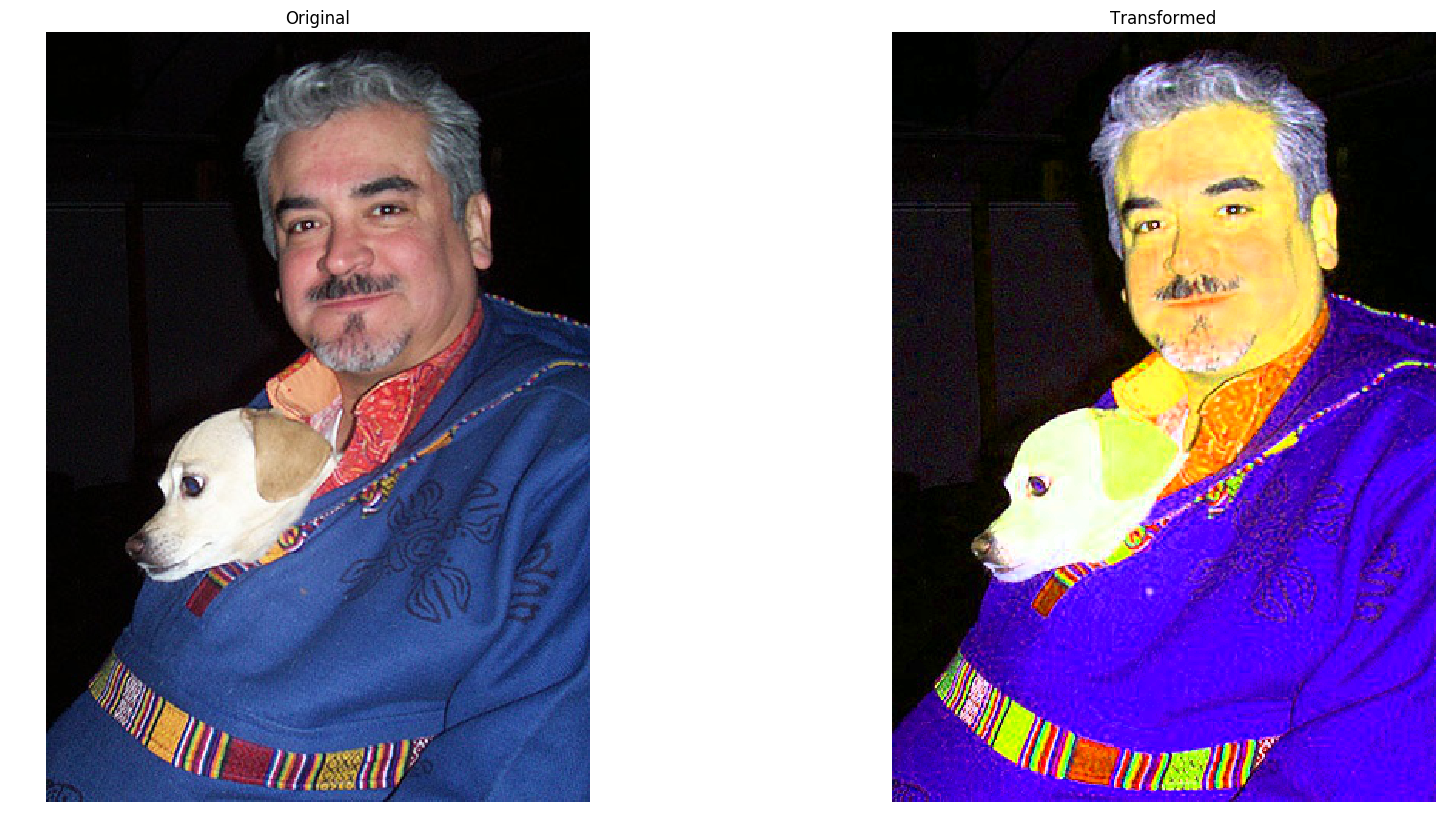

In [6]:
# Load image
img = Image.open('example.jpg')

# BaseTransform  -> Perform HSV shift
hsv = ln.data.transform.RandomHSV(
    hue=1,
    saturation=2,
    value=2
)

img_tf = hsv(img)

# Show images
fig, axes = plt.subplots(1, 2)
axes[0].imshow(np.asarray(img))
axes[0].axis('off')
axes[0].set_title('Original')
axes[1].imshow(np.asarray(img_tf))
axes[1].axis('off')
axes[1].set_title('Transformed')
plt.show()

To use [BaseMultiTransform](../api/data.rst#lightnet.data.transform.util.BaseMultiTransform) operators, you first call them with the image.
The operator will compute all the necessary values to perform the transformation, store them and apply them to the image.
Afterwards, when you call that same operator with an annotation dataframe, it will use the stored values to perform the same transformation to your annotations.

As you can see, it is important to apply the transformation in the right order, because as soon as you apply the operator to a new image, it will overwrite the transformation parameters with new ones.

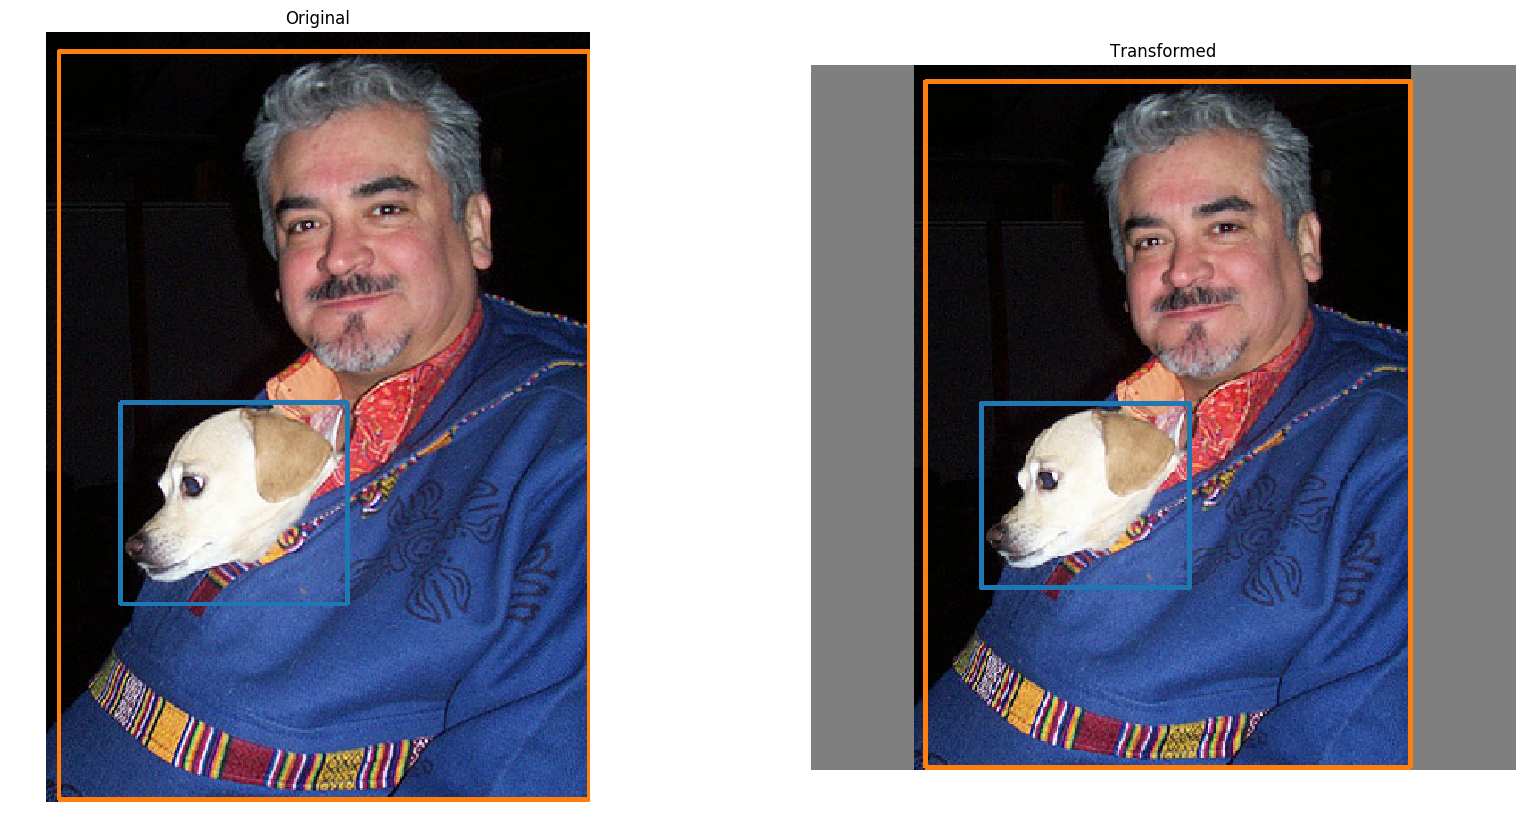

In [7]:
# Load annotations of the image
anno = bb.io.load('anno_pascalvoc', 'example.xml')

# BaseMultiTranform  -> Letterbox img/anno to 416x416
lb = ln.data.transform.Letterbox(
    dimension=(416, 416)
)

img_tf = lb(img)
anno_tf = lb(anno)

# Show images
fig, axes = plt.subplots(1, 2)
axes[0].imshow(np.asarray(bb.util.draw_boxes(img, anno)))
axes[0].axis('off')
axes[0].set_title('Original')
axes[1].imshow(np.asarray(bb.util.draw_boxes(img_tf, anno_tf)))
axes[1].axis('off')
axes[1].set_title('Transformed')
plt.show()

As you can see, all these transformation operators are meant to work seamlessly in a pytorch dataset/dataloader environment and can be used with the [torchvision.transforms.Compose](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Compose) class (or better yet, take a look at [lightnet.data.transform.Compose](../api/data.rst#lightnet.data.transform.Compose) for more extensible version).

<div class="alert alert-info">

**Note:**

If you just need a basic image dataset, which is driven by all images defined in your brambox annotation dataframe,
feel free to take a look at the [lightnet.models.BramboxDataset](../api/models.rst#lightnet.models.BramboxDataset) dataset.  
This dataset takes an annotation dataframe, an image and annotation transformation pipeline (eg. Compose) and will automatically spit out transformed images and annotations.

</div>


## Post-processing pipeline
In this final section, we will talk about the post-processing functionality included in lightnet, which allows to convert the output tensors of a detector to a brambox dataframe.

The post-processing operators are not that different from the pre-processing ones.
In fact, they are also implemented as subclasses from [BaseTransform](../api/data.rst#lightnet.data.transform.util.BaseTransform), and thus behave in exactly the same way!
The only difference lies in their input and output formats, which are different for each operator.

As an example we will show a commonly used post-processing pipeline, which is used to transform the output tensor from the [Yolo](../api/models.rst#lightnet.models.Yolo) network to a brambox detection dataframe.

<div class="alert alert-info">

**Note:**

The [TensorToBrambox](../api/data.rst#lightnet.data.transform.TensorToBrambox) function creates a valid brambox dataframe, except that the image column is just a numerical column containing the batch_number of the image.  
It is up to the user to connect these numbers to the right image name (and optionally create a categorical column).

</div>

In [8]:
# Load model
class_label_map = ['person']
model = ln.models.Yolo(num_classes=len(class_label_map))

# Create post-processing pipeline
post = ln.data.transform.Compose([
    ln.data.transform.GetBoundingBoxes(
        num_classes=model.num_classes,
        anchors=model.anchors,
        conf_thresh=0.5,
    ),
    
    ln.data.transform.NonMaxSuppression(
        nms_thresh=0.5
    ),
    
    ln.data.transform.TensorToBrambox(
        network_size=(416, 416),
        class_label_map=class_label_map,
    )
])

# Run model (on garbage random data)
input_tensor = torch.rand(2, 3, 416, 416)   # 2 random images of 416x416

with torch.no_grad():
    output_tensor = model(input_tensor)
    output_df = post(output_tensor)

# Show output
output_df.head()

,image,class_label,id,x_top_left,y_top_left,width,height,confidence
0,0,person,NaN,-8.838892,-13.819168,45.756241,62.326435,0.514521
1,0,person,NaN,25.082569,-13.797777,44.722450,56.992241,0.539932
2,0,person,NaN,56.965706,-4.884087,48.941223,42.525108,0.616681
3,0,person,NaN,121.147858,-5.000748,43.198883,40.569794,0.565906
4,0,person,NaN,147.312927,-5.713592,57.370075,43.176876,0.590265
